# <center>Exploring Hidden Markov Models with the Viterbi Algorithm</center>
## <center>A Solution by Team TheChamps</center>

**Introduction**

In this notebook, we address the problem at hand using the Viterbi algorithm, a powerful tool for solving problems involving Hidden Markov Models. Our team, TheChamps, has chosen to employ this algorithm due to its effectiveness in finding the most probable solution without relying on conventional machine learning techniques.

**Understanding the Problem**

The task at hand involves dealing with a Hidden Markov Model, a statistical model where the system being modeled is assumed to be a Markov process with hidden states. Despite the absence of "real machine learning" in our approach, the Viterbi algorithm offers a robust solution to such problems.

**Explaining the Viterbi Algorithm**

The Viterbi algorithm is a dynamic programming algorithm used to find the most likely sequence of hidden states – in our case, the most likely sequence of tags – given a sequence of observations – here, words. It efficiently computes the most probable path through a sequence of states in a Hidden Markov Model, utilizing the principles of dynamic programming.

**Application to the Problem**

We'll demonstrate the application of the Viterbi algorithm to the problem provided in this competition. While the Viterbi algorithm may yield a LB (Leaderboard) score of approximately 0.935, it serves as a valuable demonstration of its effectiveness and confirms the lack of additional information available in the data.

Our team, **TheChamps**, believes that showcasing the Viterbi algorithm not only provides insight into its functionality but also highlights its relevance in tackling problems such as the one presented in this competition. Let's proceed to implement and apply the Viterbi algorithm to our problem statement.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import f1_score, accuracy_score

In [2]:
def create_axes_grid(numplots_x, numplots_y, plotsize_x=6, plotsize_y=3):
    fig, axes = plt.subplots(numplots_y, numplots_x)
    fig.set_size_inches(plotsize_x * numplots_x, plotsize_y * numplots_y)
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    return fig, axes
    
def set_axes(axes, use_grid=True, x_val = [0,100,10,5], y_val = [-50,50,10,5]):
    axes.grid(use_grid)
    axes.tick_params(which='both', direction='inout', top=True, right=True, labelbottom=True, labelleft=True)
    axes.set_xlim(x_val[0], x_val[1])
    axes.set_ylim(y_val[0], y_val[1])
    axes.set_xticks(np.linspace(x_val[0], x_val[1], np.around((x_val[1] - x_val[0]) / x_val[2] + 1).astype(int)))
    axes.set_xticks(np.linspace(x_val[0], x_val[1], np.around((x_val[1] - x_val[0]) / x_val[3] + 1).astype(int)), minor=True)
    axes.set_yticks(np.linspace(y_val[0], y_val[1], np.around((y_val[1] - y_val[0]) / y_val[2] + 1).astype(int)))
    axes.set_yticks(np.linspace(y_val[0], y_val[1], np.around((y_val[1] - y_val[0]) / y_val[3] + 1).astype(int)), minor=True)

**Terminology**

The following terms are important to understand the algorithm. For clarity, I will use the most complex part of the training data for illustration: the part [2000000:2500000], where the number of open channels is 0-10.

The underlying process here is a Markov process with num_states possible states (here: num_states=11). The Markov property means that the probability of finding the system in state s at data point i depends only on s_i-1, the state of the previous data point. The process is therefore fully characterized by the *transition matrix P_trans*, a (num_states,num_states) Matrix where P_trans[i,j] is the probability for the system going to state j in the next step when i is the the current state.

However, the true current state of the system is unobservable, which is why they are called *Hidden Markov Models*. Instead, the system emits an observable *signal* at each time step. The probability for observing a specific signal depends only on the current state. We therefore need another matrix *P_signal* of dimension (num_states, num_signals) with num_signals = the number of possible signals. Again, P[i,j] is the probability of observing signal j if the system is currently in state i.

The algorithm also requires the initial probability distibution *p_in* of the states before the first signal observation. This is completely irrelevant in our case, we use a uniform distribution.

The final input we need is the *chain of observed signals*, in our case the signal data of length 500.000. The Viterbi algorithm then returns a chain the most probable sequence of true states that would produce the observed signal chain, i.e. the solution we're looking for in this competition. 

When I tried to understand the Viterbi algorithm, I was struck by how complicated it is usually presented. In fact, it is surprisingly simple. Here's the code:

In [3]:
def viterbi(p_trans, p_signal, p_in, signal):

    offset = 10**(-20) # added to values to avoid problems with log2(0)

    p_trans_tlog  = np.transpose(np.log2(p_trans  + offset)) # p_trans, logarithm + transposed
    p_signal_tlog = np.transpose(np.log2(p_signal + offset)) # p_signal, logarithm + transposed
    p_in_log      =              np.log2(p_in     + offset)  # p_in, logarithm

    p_state_log = [ p_in_log + p_signal_tlog[signal[0]] ] # initial state probabilities for signal element 0 

    for s in signal[1:]:
        p_state_log.append(np.max(p_state_log[-1] + p_trans_tlog, axis=1) + p_signal_tlog[s]) # the Viterbi algorithm

    states = np.argmax(p_state_log, axis=1) # finding the most probable states
    
    return states

The Viterbi algorithm works like this:

- for each signal, calculate the probability vector p_state that the signal was emitted by state i (i in [0,num_states-1]). At step 0, this is simply p_in * transpose(p_signal).
- for all following signals, calculate for each possible state i the probability that the system is now in state i like this: first, calculate the probability that the system transitioned into state i by multiplying the previous p_state with the transposed p_trans. Then take the maximum of these possibilities and multiply with transpose(p_signal).
- finally, find for each signal point the state with the highest probability (-> argmax).

If we would actually calculate the probabilities like that, especially for 500.000 signal points, we end up with probabilities in the range of 10 ** (-100000)! This wouldn't work, so we need to use logarithms of probabilities, as a result, all multiplications become additions.

That's all. Now we have to figure out P_trans and P_signal for our problem. I demonstrate this for a specific part of the training signal:

In [4]:
df_train = pd.read_csv("train.csv")
signal = df_train['signal'].values[2000000:2500000]
true_state = df_train['open_channels'].values[2000000:2500000]

Example Plot:

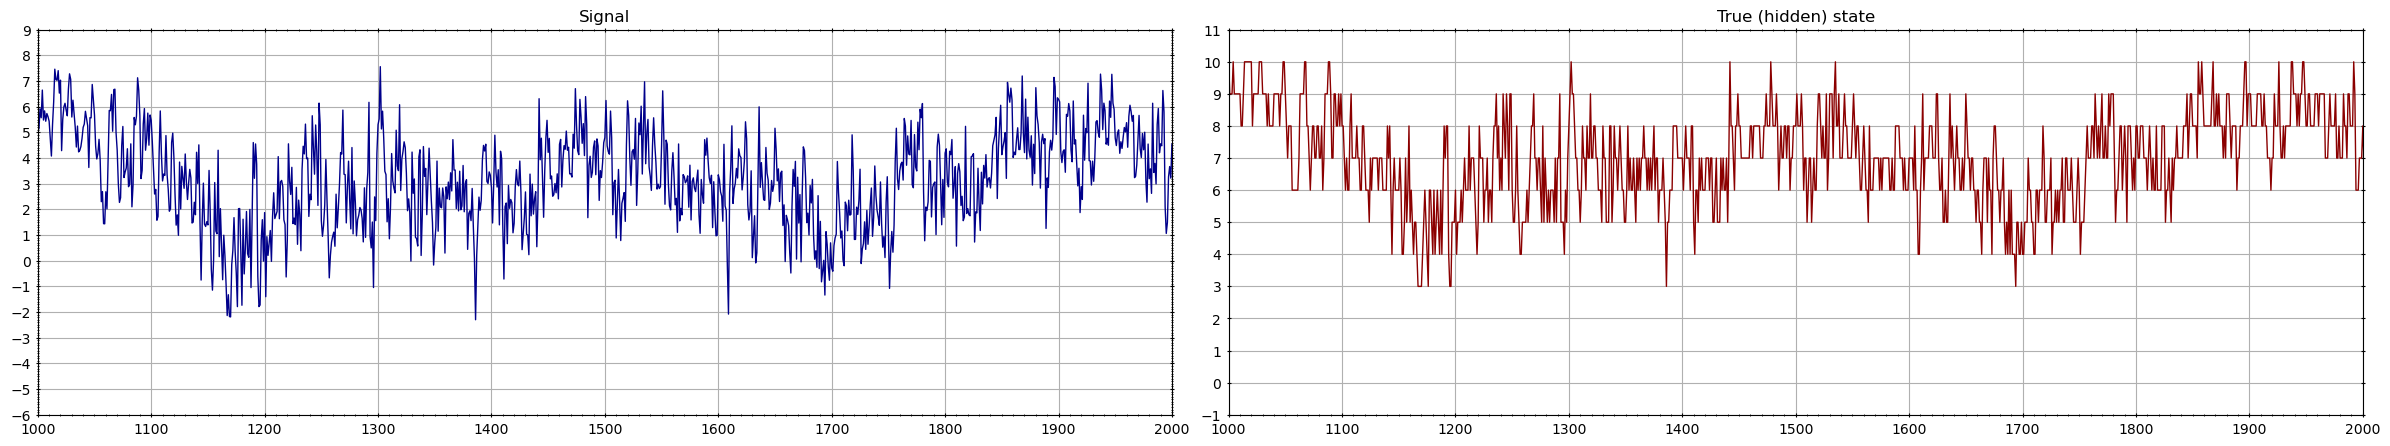

In [5]:
fig, axes = create_axes_grid(2,1,15,5)

set_axes(axes[0], x_val=[1000, 2000, 100, 10], y_val=[-6,9,1,0.1])
axes[0].set_title('Signal')
axes[0].plot(signal, linewidth=1, color='darkblue');

set_axes(axes[1], x_val=[1000, 2000, 100, 10], y_val=[-1,11,1,1])
axes[1].set_title('True (hidden) state')
axes[1].plot(true_state, linewidth=1, color='darkred');

## Calculate P_trans from the true states:

In [6]:
def calc_markov_p_trans(states):
    max_state = np.max(states)
    states_next = np.roll(states, -1)
    matrix = []
    for i in range(max_state + 1):
        current_row = np.histogram(states_next[states == i], bins=np.arange(max_state + 2))[0]
        if np.sum(current_row) == 0: # if a state doesn't appear in states...
            current_row = np.ones(max_state + 1) / (max_state + 1) # ...use uniform probability
        else:
            current_row = current_row / np.sum(current_row) # normalize to 1
        matrix.append(current_row)
    return np.array(matrix)

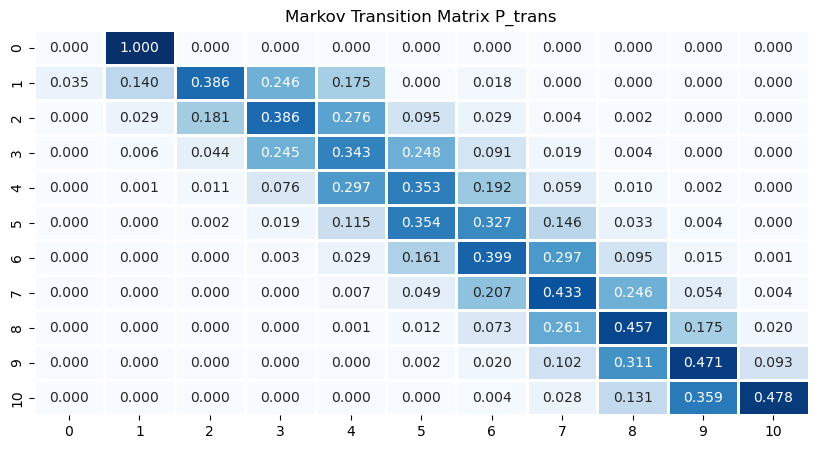

In [7]:
p_trans = calc_markov_p_trans(true_state)

fig, axes = create_axes_grid(1,1,10,5)
axes.set_title('Markov Transition Matrix P_trans')
sns.heatmap(
    p_trans,
    annot=True, fmt='.3f', cmap='Blues', cbar=False,
    ax=axes, vmin=0, vmax=0.5, linewidths=2);

## Then we need to calculate P_signal

- Use the actual distribution of the signal for each of the true states. 
- We can do this because it's training data and we know the true state.

Important: the signal we have is actually a (practically) continuous floating point number. 
We need discrete signals. So, we need to put the signal into discrete bins. Here, I use 1000 bins. Again, I've tried using more, it doesn't help.

In [8]:
def calc_markov_p_signal(state, signal, num_bins = 1000):
    states_range = np.arange(state.min(), state.max() + 1)
    signal_bins = np.linspace(signal.min(), signal.max(), num_bins + 1)
    p_signal = np.array([ np.histogram(signal[state == s], bins=signal_bins)[0] for s in states_range ])
    p_signal = np.array([ p / np.sum(p) for p in p_signal ]) # normalize to 1
    return p_signal, signal_bins

In [9]:
p_signal, signal_bins = calc_markov_p_signal(true_state, signal)

Here you can see each probability distribution:

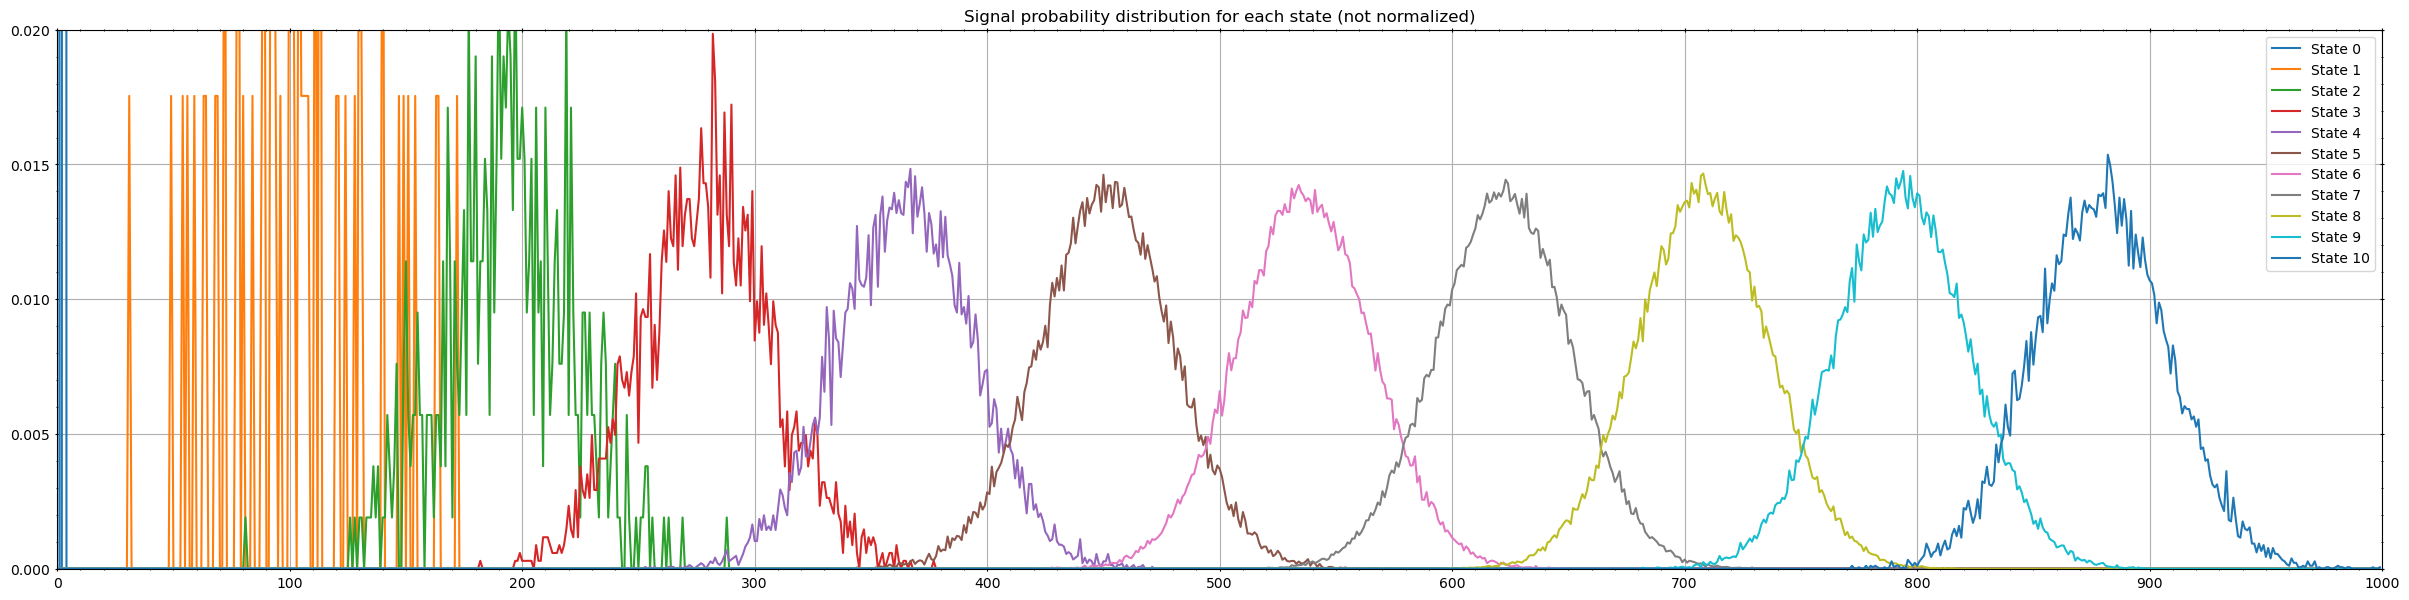

In [10]:
fig, axes = create_axes_grid(1,1,30,7)
set_axes(axes, x_val=[0, 1000, 100, 10], y_val=[0,0.02,0.005,0.001])
axes.set_title('Signal probability distribution for each state (not normalized)')
for s,p in enumerate(p_signal):
    axes.plot(p, label="State "+str(s));
axes.legend();

They are all Gaussian with a common standard deviation, however, there are not enough data points for low states. We could calculate smooth Gaussians for each state (I did this via calculating weighted mean / std) and linear interpolation, but it really doesn't change much. It's simply not a problem when p_signal is bad in places where there are anyway not many points.

Let's visualize P_signal again in matrix form:

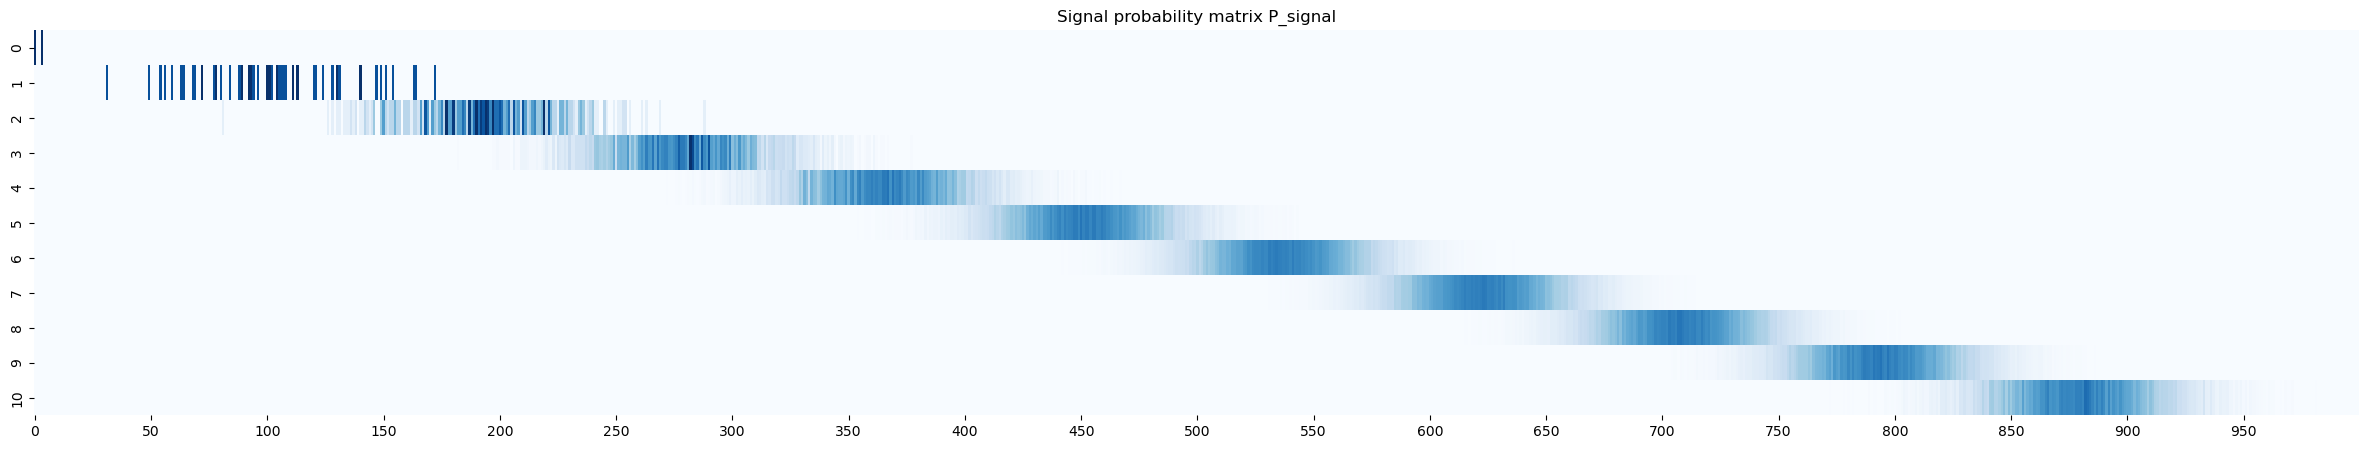

In [11]:
fig, axes = create_axes_grid(1,1,30,5)
axes.set_title('Signal probability matrix P_signal')
sns.heatmap(
    p_signal,
    annot=False, cmap='Blues', cbar=False, xticklabels=50,
    ax=axes, vmin=0, vmax=0.02);

We finally need to put the actual signal into these bins as well:

In [12]:
def digitize_signal(signal, signal_bins):
    signal_dig = np.digitize(signal, bins=signal_bins) - 1 # these -1 and -2 are necessary because of the way...
    signal_dig = np.minimum(signal_dig, len(signal_bins) - 2) # ... numpy.digitize works
    return signal_dig

In [13]:
signal_dig = digitize_signal(signal, signal_bins)
print ("Signal bin values:", signal_dig)

Signal bin values: [896 872 883 ... 531 658 600]


And the uniform distribution for p_in:

In [14]:
p_in = np.ones(len(p_trans)) / len(p_trans)
print("Initial probability p_in =", p_in)

Initial probability p_in = [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]


All set. One line of code and we have our solution:

In [15]:
viterbi_state = viterbi(p_trans, p_signal, p_in, signal_dig)
print("State sequence as predicted by Viterbi algorithm :", viterbi_state)

State sequence as predicted by Viterbi algorithm : [10 10 10 ...  6  7  7]


## A visual comparison:

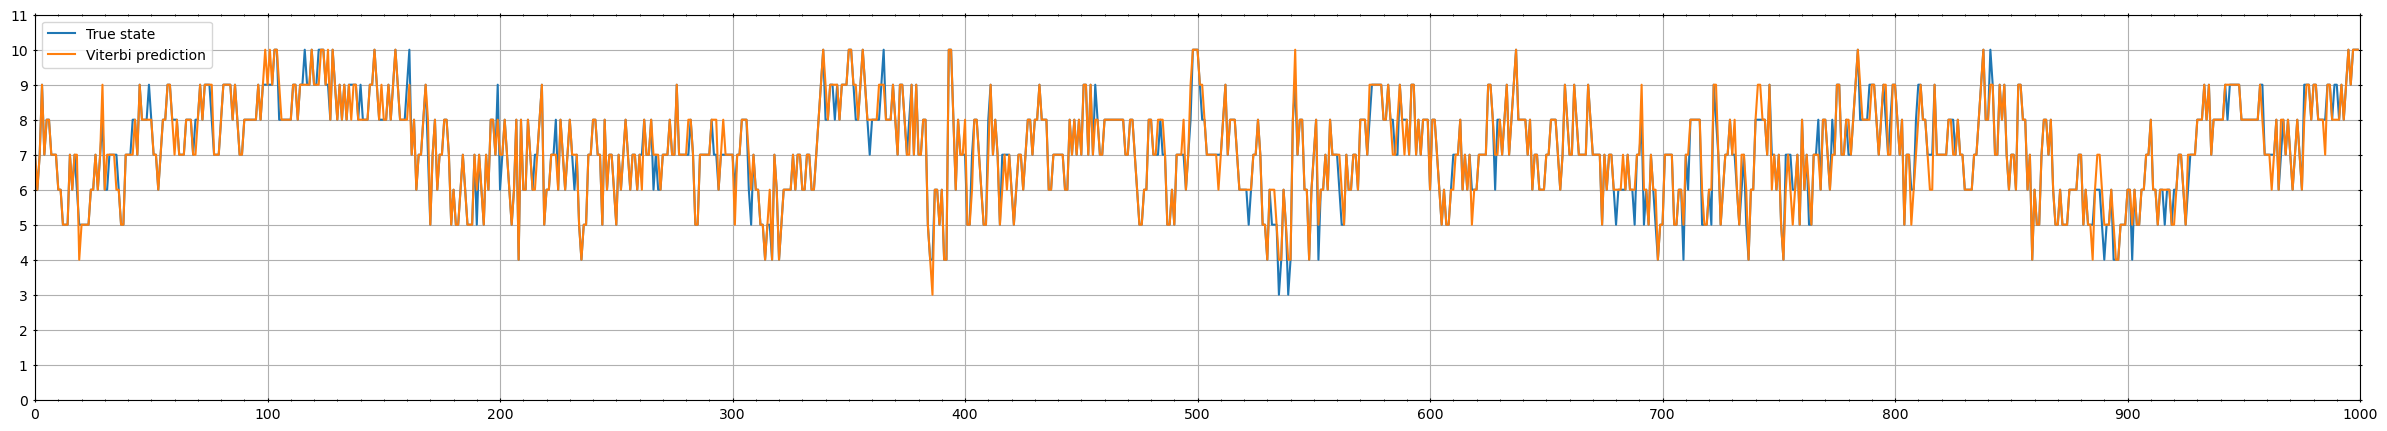

In [16]:
fig, axes = create_axes_grid(1,1,30,5)
set_axes(axes, x_val=[0,1000,100,10], y_val=[0,11,1,1])

axes.plot(true_state[10000:11000], label="True state");
axes.plot(viterbi_state[10000:11000], label="Viterbi prediction");
axes.legend();

In [17]:
print("Accuracy =", accuracy_score(y_pred=viterbi_state, y_true=true_state))
print("F1 macro =", f1_score(y_pred=viterbi_state, y_true=true_state, average='macro'))

Accuracy = 0.87987
F1 macro = 0.8847009949714352


In [20]:
with np.load('train_detrend.npz', allow_pickle=True) as data:
    train_signal = data['train_signal']
    train_opchan = data['train_opench']
    train_groups = data['train_groups']
    
with np.load('test_detrend.npz', allow_pickle=True) as data:
    test_signal = data['test_signal']
    test_groups = data['test_groups']

Predict the test states using p_trans and p_signal from the training data:

In [21]:
%%time

train_group_ids = [ [0,1,2], [3,7], [4,8], [6,9], [5,10]  ]
test_group_ids  = [ [0,3,8,10,11], [4], [1,9], [2,6], [5,7] ]
test_y_pred = [None] * 12

for train_groups, test_groups in zip(train_group_ids, test_group_ids):
    
    print("train_groups :", train_groups, ", test_groups :", test_groups)

    signal_train     = np.concatenate(train_signal[train_groups])
    true_state_train = np.concatenate(train_opchan[train_groups])
    
    p_trans               = calc_markov_p_trans(true_state_train)
    p_signal, signal_bins = calc_markov_p_signal(true_state_train, signal_train)
    p_in = np.ones(len(p_trans)) / len(p_trans)

    for test_grp in test_groups:
        signal_dig = digitize_signal(test_signal[test_grp], signal_bins)
        test_y_pred[test_grp] = viterbi(p_trans, p_signal, p_in, signal_dig)
        
test_y_pred = np.concatenate(test_y_pred)

train_groups : [0, 1, 2] , test_groups : [0, 3, 8, 10, 11]
train_groups : [3, 7] , test_groups : [4]
train_groups : [4, 8] , test_groups : [1, 9]
train_groups : [6, 9] , test_groups : [2, 6]
train_groups : [5, 10] , test_groups : [5, 7]
CPU times: total: 8.12 s
Wall time: 15.8 s


## <center> It scores 0.932. By improving P_signal, you can get up to 0.935. <center>